In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_io as tfio
# import tensorflow_addons as tfa

physical_devices = tf.config.list_physical_devices('GPU')
for pdev in physical_devices:
    tf.config.experimental.set_memory_growth(pdev, True)

from micron2.clustering import MoCo, MoCo_Classifier, UpdateQueue
from micron2.data import stream_dataset, stream_dataset_parallel

import h5py
import tqdm.auto as tqdm
from tqdm.keras import TqdmCallback

AUTO = tf.data.experimental.AUTOTUNE

2021-07-20 11:04:59.665570: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-20 11:05:00.403569: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-20 11:05:00.443191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-07-20 11:05:00.443244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-20 11:05:00.443979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:21:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz cor

In [6]:
use_channels = ['CD8', 'CD4', 'PanCytoK', 'PD-1', 'CD45', 
                'CD20', 'CD138', 'CD68', 'CD31', 'CD11c', 
                'FOXP3', 'CXCR5', 'CXCL13', 'CD3e', 
                'Ki-67', 'LAG3', 'HLA-DR', 'aSMA']

In [8]:
# Change this cell to load from multiple samples, and concatenate. 
# make sure to place channels correctly, in case they're permuted for some reason between collections.
import glob
srch = '/common/ingn/CODEX_PROCESSED_DATA/pembroRT_immune/phase2/*/collection*'

image_files = sorted(glob.glob(f'{srch}/training_cells_images.npy'))
annot_files = sorted(glob.glob(f'{srch}/training_cells_annots.npy'))
channel_files = sorted(glob.glob(f'{srch}/training_cells_channels.npy'))

for f in image_files:
    print(f)

images = np.concatenate([np.load(f) for f in image_files], axis=0)
annots = np.concatenate([np.load(f) for f in annot_files], axis=0)
channels = np.load(channel_files[0])

channels = {k:i for i,k in enumerate(channels)}

print(images.shape, images.dtype)
print(annots.shape)
print(np.unique(annots, return_counts=True))
print(channels)

## subset channels
# ch_indices = [channels[ch] for ch in use_channels]
# images = images[:,:,:,ch_indices]
# print(images.shape)
# channels = {k:v for k,v in channels.items() if k in use_channels}

u_annots, annots_int = np.unique(annots, return_inverse=True)
labels = np.eye(len(u_annots))[annots_int]
labels = labels[:,1:]

print(labels.shape)
print('labelled cells:', np.sum(np.sum(labels, axis=1)>0))

/common/ingn/CODEX_PROCESSED_DATA/pembroRT_immune/phase2/210701_PembroRT_Cas18_TLSpanel_reg1/collection-21-Jul-18-19-33-17/training_cells_images.npy
/common/ingn/CODEX_PROCESSED_DATA/pembroRT_immune/phase2/210701_PembroRT_Cas18_TLSpanel_reg2/collection-21-Jul-18-15-08-49/training_cells_images.npy
/common/ingn/CODEX_PROCESSED_DATA/pembroRT_immune/phase2/210701_PembroRT_Cas18_TLSpanel_reg2/collection-21-Jul-18-17-33-48/training_cells_images.npy
/common/ingn/CODEX_PROCESSED_DATA/pembroRT_immune/phase2/210701_PembroRT_Cas18_TLSpanel_reg2/collection-21-Jul-18-21-36-20/training_cells_images.npy
/common/ingn/CODEX_PROCESSED_DATA/pembroRT_immune/phase2/210701_PembroRT_Cas18_TLSpanel_reg3/collection-21-Jul-18-16-02-55/training_cells_images.npy
/common/ingn/CODEX_PROCESSED_DATA/pembroRT_immune/phase2/210701_PembroRT_Cas18_TLSpanel_reg3/collection-21-Jul-18-18-08-54/training_cells_images.npy
/common/ingn/CODEX_PROCESSED_DATA/pembroRT_immune/phase2/210702_PembroRT_Cas19_TLSpanel_reg2/collection-21

In [3]:
# ## subtract the average of each channel
# channel_means = {}
# for ch,i in channels.items():
#     stack = images[:,:,:,i]
#     mn = np.mean(stack, axis=0, keepdims=True)
#     print(ch, i, stack.shape, mn.shape)
#     channel_means[ch] = mn.copy().astype(np.float32)
    
# # images_pp = images.copy().astype(np.float32)
# images = images.astype(np.float32)
# for ch, mn in channel_means.items():
#     if ch=='DAPI':continue
#     k = channels[ch]
#     print(ch,k,mn.shape,mn.dtype)
#     images[:,:,:,k] -= mn

In [9]:
for u in u_annots:
    print(f'{u}: {np.sum(annots==u)}')

: 121229
Bcell: 161
CD4T: 133
CD8T: 171
DC: 14
Endothelial: 77
Epithelial: 162
Mac: 62
Plasma: 65
Stromal: 18


In [5]:
!pwd

/home/ingn/devel/micron2/notebooks/devel_debug


In [10]:
# input_size = 64
crop_size = 48
batch_size = 256
max_queue_len = 1024*10
n_channels = len(channels)

outdir = '/home/ingn/devel/micron2/notebooks/devel_debug/moco-models'
if not os.path.isdir(outdir):
    os.makedirs(outdir)
    
with open(f'{outdir}/channels.txt', 'w+') as f:
    for c in channels.keys():
        f.write(f'{c}\n')

In [11]:
def process(x,y):
    """
    x is [N, h, w, c]
    """
    x = tf.cast(x, tf.float32)/255.
    
    # channel drop
    
    x = tf.image.random_crop(x, [crop_size, crop_size, n_channels])
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    
    return x,y
    

image_dataset = tf.data.Dataset.from_tensor_slices(images)
label_dataset = tf.data.Dataset.from_tensor_slices(labels)
dataset = (tf.data.Dataset.zip((image_dataset, label_dataset)) 
           .shuffle(2048, reshuffle_each_iteration=True)
           .map(process, num_parallel_calls=4)
           .batch(batch_size, drop_remainder=True)
           .prefetch(1)
          )
for batch,label in dataset:
    print(batch.shape, label.shape)
    break

2021-07-20 11:08:13.409975: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-20 11:08:13.597089: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-07-20 11:08:13.597143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-20 11:08:13.597832: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:21:00.0 name: GeForce 

(256, 48, 48, 18) (256, 9)


2021-07-20 11:08:31.307813: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-20 11:08:31.330082: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2900065000 Hz


In [12]:
sample_x = tf.zeros([1, crop_size, crop_size, len(channels)],dtype=tf.float32)
model = MoCo_Classifier(data_shape=[crop_size, crop_size, len(channels)], 
                        z_dim=256, 
                        n_classes=labels.shape[1],
                        mlp_dim=128,
                        max_queue_len=max_queue_len,  
                        batch_size=batch_size, 
                        temp=0.1, 
                        encoder_type='ResNet50V2')

model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,)
z = model(sample_x)
g = model.encode_g(sample_x)
k = model.encode_k(sample_x)
y = model.classifier(sample_x)

print(z.shape)
print(g.shape)
print(k.shape)
print(y.shape)

model.summary()

Q: (10240, 256)


/home/ingn/miniconda3/envs/micron2-tf/lib/python3.9/site-packages/tensorflow/python/keras/applications/imagenet_utils.py:331: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 18 input channels.
  warnings.warn('This model usually expects 1 or 3 input channels. '
/home/ingn/miniconda3/envs/micron2-tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-07-20 11:08:32.489294: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-07-20 11:08:32.881835: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8200
2021-07-20 11:08:33.530121: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-20 11:08:33.911288: I tensorflow/stream_executor/platform/default

(1, 256)
(1, 256)
(1, 256)
(1, 9)
Model: "mo_co__classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  28987072  
_________________________________________________________________
encoder_1 (Encoder)          multiple                  28987072  
_________________________________________________________________
classifier (Classifier)      multiple                  29021129  
Total params: 60,629,641
Trainable params: 57,917,321
Non-trainable params: 2,712,320
_________________________________________________________________


In [13]:
model.fit(dataset, epochs=10, verbose=0,
          callbacks = [UpdateQueue(0.999, max_queue_len), 
                       TqdmCallback(verbose=2)]
         )

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/476 [00:00<?, ?batch/s]

  0%|          | 0.00/476 [00:00<?, ?batch/s]

  0%|          | 0.00/476 [00:00<?, ?batch/s]

  0%|          | 0.00/476 [00:00<?, ?batch/s]

  0%|          | 0.00/476 [00:00<?, ?batch/s]

  0%|          | 0.00/476 [00:00<?, ?batch/s]

  0%|          | 0.00/476 [00:00<?, ?batch/s]

  0%|          | 0.00/476 [00:00<?, ?batch/s]

  0%|          | 0.00/476 [00:00<?, ?batch/s]

  0%|          | 0.00/476 [00:00<?, ?batch/s]

In [14]:
has_labels = labels.sum(axis=1) > 0
print(np.sum(has_labels))
labelled_images = images[has_labels]
use_labels = labels[has_labels]

def process(x,y):
    """
    x is [N, h, w, c]
    """
    x = tf.cast(x, tf.float32)/255.
    
    x = tf.image.central_crop(x, 0.75) # 48 / 64
#     x = tf.image.random_flip_left_right(x)
#     x = tf.image.random_flip_up_down(x)

    return x,y

image_dataset = tf.data.Dataset.from_tensor_slices(labelled_images)
label_dataset = tf.data.Dataset.from_tensor_slices(use_labels)
dataset = (tf.data.Dataset.zip((image_dataset, label_dataset)) 
           .repeat(50)
           .shuffle(1024, reshuffle_each_iteration=True)
           .map(process, num_parallel_calls=4)
           .batch(batch_size, drop_remainder=True)
           .prefetch(1)
          )

for batch in dataset:
    batch_images, batch_labels = batch
    print(batch_images.shape, batch_labels.shape)
    break

863
(256, 48, 48, 18) (256, 9)


In [15]:
xent = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
loss_history = []
z_snapshots = []
label_snapshots = []
pred_snapshots = []
with tqdm.tqdm(dataset) as pbar:
    for batch in pbar:
        batch_images, batch_labels = batch
        with tf.GradientTape() as tape:
            z = model.encode_g(batch_images)
            y = model.classifier(batch_images)
            loss = xent(batch_labels, y)
            
        variables = model.classifier.mlp_hid.trainable_variables +\
                    model.classifier.mlp_out.trainable_variables
        
        #variables = model.classifier.trainable_variables
        grads = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(grads, variables))
        
        loss_history.append(loss.numpy())
        
        if np.abs(np.random.randn()) > 2.5:
            pred_snapshots.append(y.numpy())
            label_snapshots.append(batch_labels.numpy())
            z_snapshots.append(z.numpy())
            
        
        pbar.set_description(f'loss={np.mean(loss_history):1.4e}')
        

  0%|          | 0/168 [00:00<?, ?it/s]

In [16]:
import umap
from matplotlib import pyplot as plt

In [17]:
# i = 4
# y = label_snapshots[i]
# print(y.shape)
# mx = np.argmax(y,axis=1)
# print(mx.shape)

# z = z_snapshots[i]
# print(z.shape)

# emb = umap.UMAP().fit_transform(z)
# print(emb.shape)

# for m in np.unique(mx):
#     plt.scatter(emb[mx==m,0], emb[mx==m,1])

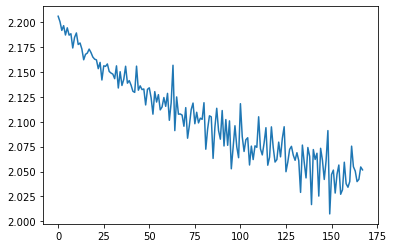

In [18]:
plt.plot(range(len(loss_history)), loss_history)

In [19]:
# # change the classifier loss weight
# model.alpha = 1
# model.beta = 0
# model.fit(dataset, epochs=1, verbose=0,
#           callbacks = [UpdateQueue(0.999, max_queue_len), 
#                        TqdmCallback(verbose=2)]
#          )

In [20]:
print(outdir)
model.save_weights(f'{outdir}/weights.h5')
model.encode_g.save_weights(f'{outdir}/weights_g.h5')
model.encode_k.save_weights(f'{outdir}/weights_k.h5')
model.classifier.save_weights(f'{outdir}/weights_cls.h5')

/home/ingn/devel/micron2/notebooks/devel_debug/moco-models
